In [1]:
%ls ../input
%ls ../input/synimg/synimg/train/Beijing | head -5


synimg/
train-Beijing-1050000.jpg
train-Beijing-1050001.jpg
train-Beijing-1050002.jpg
train-Beijing-1050003.jpg
train-Beijing-1050004.jpg


In [2]:

import skimage.io as io
import os
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import sys
sys.path.append("../src")  # This is relative to test directory e.g. /realestatereview/test
from data import read_data_from_file, get_labels



In [3]:
WIDTH = 64
HEIGHT = 32
ROOT_PATH = '../input/synimg/'



# Step 1: Doing input/output

In [4]:
def read_data_from_file(filename, nrows=None, max_per_class=None, shuffle=False):
    '''
        File is in the format of data.csv or data_nostyle.csv,
        containing location of each image and IDs and/or la
        filename example: 'synimg/test/data_nostyle.csv'
    '''
    data = pd.read_csv(ROOT_PATH + filename, nrows=nrows)
    if max_per_class:
        data = data.groupby('style_name').head(max_per_class).reset_index()
    # print("Shape and review after getting max per group:\n", data.shape, "\n", data.head(20))
    if shuffle:
        data = data.sample(frac=1.0) 
    # Read images
#     all_images = read_images(data, max_per_class) # includes caching

    return data

MAX_PER_CLASS=500
train_data =  read_data_from_file('synimg/train/data.csv', max_per_class=None, shuffle=False)
test_data = read_data_from_file('synimg/test/data_nostyle.csv')
print(train_data.head(1))
train_data.head(10)


        id style_name                      file  \
0  1000000     Luanda  train-Luanda-1000000.jpg   

                                       filepath  
0  synimg/train/Luanda/train-Luanda-1000000.jpg  


,id,style_name,file,filepath
0,1000000,Luanda,train-Luanda-1000000.jpg,synimg/train/Luanda/train-Luanda-1000000.jpg
1,1000001,Luanda,train-Luanda-1000001.jpg,synimg/train/Luanda/train-Luanda-1000001.jpg
2,1000002,Luanda,train-Luanda-1000002.jpg,synimg/train/Luanda/train-Luanda-1000002.jpg
3,1000003,Luanda,train-Luanda-1000003.jpg,synimg/train/Luanda/train-Luanda-1000003.jpg
4,1000004,Luanda,train-Luanda-1000004.jpg,synimg/train/Luanda/train-Luanda-1000004.jpg
5,1000005,Luanda,train-Luanda-1000005.jpg,synimg/train/Luanda/train-Luanda-1000005.jpg
6,1000006,Luanda,train-Luanda-1000006.jpg,synimg/train/Luanda/train-Luanda-1000006.jpg
7,1000007,Luanda,train-Luanda-1000007.jpg,synimg/train/Luanda/train-Luanda-1000007.jpg
8,1000008,Luanda,train-Luanda-1000008.jpg,synimg/train/Luanda/train-Luanda-1000008.jpg
9,1000009,Luanda,train-Luanda-1000009.jpg,synimg/train/Luanda/train-Luanda-1000009.jpg


In [5]:
from PIL import Image

def read_images(data):
    X = []
    for filepath in data['filepath']:
        pil_img = Image.open(ROOT_PATH + filepath)
        img_array = np.array(pil_img) # [0., 255.0]
        X.append(img_array)
    return np.stack(X)

#     all_images = []
#     for idx, row in data.iterrows():
#         img = io.imread(ROOT_PATH + row['filepath'])
#         all_images.append(img)
#     return all_images

In [6]:
# train_images = read_images(train_data)
test_images = read_images(test_data)
label_encoder, train_data = get_labels(train_data, print_classes=False) # one-hot encode, returns in column 'style_id'

In [9]:
# Do this to shuffle data if needed
train_data = train_data.sample(frac = 1.0)
train_images = read_images(train_data)

## let's try to see an image

[ 75 236  72]


236

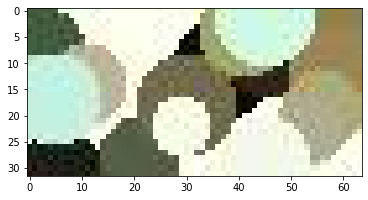

In [12]:
plt.imshow(train_images[2])
print(train_images[0][2][5])
train_images[0][2][5][1]

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


NUM_CLASSES = 10

def normalise(images):
    images = np.array(images).astype(np.float32)

    for idx, image in enumerate(images):
#         images[idx] = (images[idx] / 255.0 * 2.0) - 1.0
        images[idx] = (images[idx] / 255.0 )
        
    return images

X_train, X_test = normalise(train_images), normalise(test_images)
# y_train = keras.utils.to_categorical(list(train_data['style_id']), NUM_CLASSES) 


Using TensorFlow backend.


In [14]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.model_selection import train_test_split


styles_encoder = LabelEncoder().fit(train_data['style_name'].unique()) # use this for sparse format not one-hot
y_train =  styles_encoder.transform(train_data['style_name'])

X, X_cv, y, y_cv = train_test_split(
    X_train, y_train,
    test_size = 0.05,
    random_state = 15
)

print("training label distribution", Counter(y))
print("validation label distribution", Counter(y_cv))

print("X_train[0]", X_train[0])
print("y_train[0]",y_train[0])
print("Shapes x_train, y_train", X_train.shape, y_train.shape) # 500, 32, 64, 3
print("Shapes x_test", X_test.shape) # 500, 32, 64, 3

training label distribution Counter({0: 9547, 6: 9540, 3: 9519, 9: 9515, 1: 9506, 8: 9502, 4: 9488, 7: 9481, 2: 9454, 5: 9448})
validation label distribution Counter({5: 552, 2: 546, 7: 519, 4: 512, 8: 498, 1: 494, 9: 485, 3: 481, 6: 460, 0: 453})
X_train[0] [[[0.14901961 1.         0.21568628]
  [0.27450982 0.93333334 0.2627451 ]
  [0.36862746 0.8745098  0.31764707]
  ...
  [0.9764706  1.         0.972549  ]
  [0.96862745 1.         0.9764706 ]
  [0.9647059  1.         0.9843137 ]]

 [[0.1764706  0.9882353  0.23529412]
  [0.26666668 0.9411765  0.26666668]
  [0.34901962 0.89411765 0.29411766]
  ...
  [0.98039216 1.         0.95686275]
  [0.9764706  1.         0.972549  ]
  [0.9764706  1.         0.9764706 ]]

 [[0.22352941 0.9607843  0.28235295]
  [0.25490198 0.94509804 0.28235295]
  [0.32941177 0.9098039  0.28627452]
  ...
  [0.99215686 1.         0.94509804]
  [0.99215686 1.         0.9490196 ]
  [0.99215686 1.         0.95686275]]

 ...

 [[1.         0.9843137  0.92941177]
  [1.   

In [15]:
NUM_CLASSES = 10
BATCH_SIZE = 1024

## Build model

In [ ]:
model = Sequential()

model.add(Conv2D(40, kernel_size=5, padding="same",input_shape=(32, 64, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


# 2nd convo layer - increase feature map
model.add(Conv2D(70, kernel_size=3, padding="same", activation = 'relu'))
model.add(Conv2D(200, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))

model.add(Conv2D(512, kernel_size=3, padding="valid", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))

# Dense layer
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


####

# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
#                 input_shape=[32, 64, 3]))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # add 2nd conv layer
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(10, activation='relu'))
# model.add(Dense(NUM_CLASSES, activation='softmax'))

# model.compile(loss=keras.losses.categorical_crossentropy,
#             optimizer=keras.optimizers.Adadelta(),
#             metrics=['accuracy'])
print(model.summary())


In [26]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

inputs = Input(shape=(32, 64, 3))

def conv_block(inp, filters, kernel_size, strides):
    block = Conv2D(filters=filters, kernel_size=kernel_size, 
                   strides=strides, padding='same', 
                   kernel_initializer='he_normal', activation=None, 
                   use_bias=False)(inp)
    block = BatchNormalization()(block)
    return Activation('relu')(block)

def res_net_block(inp, filters, kernel_size=3):
    # main path is two conv blocks with first reducing spatial size using striding
    main_path = conv_block(inp, filters, kernel_size, strides=2)    
    main_path = conv_block(main_path, filters, kernel_size, strides=1)
    #main_path = conv_block(main_path, filters, kernel_size, strides=1)
    
    # residual path is a linear projection with stride=2 to do equivalent
    # spatial reduction
    residual_path = Conv2D(filters=filters, kernel_size=1,
                           strides=2, padding='same', activation=None)(inp) 
    
    # TODO: review combos of BN positioning from "Identity mappings in deep residual networks"
    model = Add()([main_path, residual_path])
    model = BatchNormalization()(model)
    return Activation('relu')(model)

resnet = res_net_block(inputs, filters=16, kernel_size=5)
resnet = res_net_block(resnet, filters=32)
resnet = res_net_block(resnet, filters=32)
resnet = res_net_block(resnet, filters=32)

mlp = Flatten()(resnet)
mlp = Dropout(rate=0.5)(mlp)

mlp = Dense(units=64, activation=None, use_bias=False)(mlp)
mlp = BatchNormalization()(mlp)
mlp = Activation('relu')(mlp)

predictions = Dense(units=10, activation='softmax')(mlp)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

model.compile(optimizers.Adam(lr=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 16, 32, 16)   1200        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 16, 32, 16)   64          conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 16, 32, 16)   0           batch_normalization_26[0][0]     
____________________________________________________________________________________________

In [81]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
EPOCHS=3
BATCH_SIZE=512

X_train, X_test = normalise(train_images), normalise(test_images)
X, X_cv, y, y_cv = train_test_split(
    X_train, y_train,
    test_size = 0.01,
    random_state = 15
)
print("Training starting...")

model.fit(X, y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        validation_data=(X_cv, y_cv))
score = model.evaluate(X_cv, y_cv, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Training starting...
Train on 99000 samples, validate on 1000 samples
Epoch 1/3
99000/99000 [==============================] - 148s 1ms/sample - loss: 0.0753 - acc: 0.9698 - val_loss: 0.1203 - val_acc: 0.9590
Epoch 2/3
 1536/99000 [..............................] - ETA: 2:20 - loss: 0.0699 - acc: 0.9688

KeyboardInterrupt: 

array([[[0.972549  , 1.        , 0.7764706 ],
        [1.        , 1.        , 0.8509804 ],
        [1.        , 0.9019608 , 1.        ],
        ...,
        [0.7411765 , 0.42352942, 0.4509804 ],
        [0.67058825, 0.4627451 , 0.43137255],
        [0.60784316, 0.5019608 , 0.3882353 ]],

       [[0.9607843 , 1.        , 0.8117647 ],
        [1.        , 1.        , 0.8901961 ],
        [1.        , 0.91764706, 1.        ],
        ...,
        [0.65882355, 0.4627451 , 0.46666667],
        [0.654902  , 0.47058824, 0.4392157 ],
        [0.6627451 , 0.47058824, 0.40392157]],

       [[0.9843137 , 1.        , 0.89411765],
        [0.99607843, 1.        , 0.91764706],
        [0.95686275, 0.8156863 , 0.9882353 ],
        ...,
        [0.6431373 , 0.46666667, 0.47843137],
        [0.7176471 , 0.43137255, 0.45882353],
        [0.8117647 , 0.39215687, 0.41568628]],

       ...,

       [[0.99215686, 1.        , 0.92941177],
        [0.99215686, 1.        , 0.92941177],
        [0.99215686, 1

# Data augmentation

In [69]:
from keras.preprocessing.image import ImageDataGenerator


BATCH_SIZE = 64

X_train = X_train.reshape(-1,32,64,3)
X_test = X_test.reshape(-1,32,64,3)

X_train, X_test = normalise(train_images), normalise(test_images)
X, X_cv, y, y_cv = train_test_split(
    X_train, y_train,
    test_size = 0.05,
    random_state = 15
)




datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    fill_mode='nearest',
    validation_split = 0.05
    )

# generator = datagen.flow_from_directory(
#         'data/test',
#         target_size=(150, 150),
#         batch_size=16,
#         class_mode=None,  # only data, no labels
#         shuffle=False)  # keep data in same order as labels


datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training')
validation_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation')


# # fits the model on batches with real-time data augmentation:
history = model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    steps_per_epoch = len(train_generator) / BATCH_SIZE,
                    validation_steps = len(validation_generator) / BATCH_SIZE,
                    epochs = 20,
                    workers=20)

Epoch 1/20
24/23 [===============================] - 3s 133ms/step - loss: 0.1743 - acc: 0.9349 - val_loss: 116.6425 - val_acc: 0.2344
Epoch 2/20
24/23 [===============================] - 3s 128ms/step - loss: 0.1562 - acc: 0.9310 - val_loss: 33.3861 - val_acc: 0.3516
Epoch 3/20
24/23 [===============================] - 3s 131ms/step - loss: 0.1798 - acc: 0.9329 - val_loss: 7.9898 - val_acc: 0.6016
Epoch 4/20
24/23 [===============================] - 3s 135ms/step - loss: 0.1645 - acc: 0.9284 - val_loss: 3.1891 - val_acc: 0.8281
Epoch 5/20
24/23 [===============================] - 3s 130ms/step - loss: 0.1585 - acc: 0.9375 - val_loss: 1.8164 - val_acc: 0.8438
Epoch 6/20
24/23 [===============================] - 3s 134ms/step - loss: 0.1658 - acc: 0.9323 - val_loss: 1.1751 - val_acc: 0.8359
Epoch 7/20
24/23 [===============================] - 3s 130ms/step - loss: 0.1657 - acc: 0.9368 - val_loss: 0.6347 - val_acc: 0.8828
Epoch 8/20
24/23 [===============================] - 3s 135ms/step

In [61]:
# datagen_test = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=10,
#     fill_mode='nearest',
#     validation_split = 0.05
# )

# # generator = datagen.flow_from_directory(
# #         'data/test',
# #         target_size=(150, 150),
# #         batch_size=16,
# #         class_mode=None,  # only data, no labels
# #         shuffle=False)  # keep data in same order as labels

# datagen_test.fit(X_test)
# test_generator = datagen_test.flow(X_test)
# preds = model.predict_generator(test_generator)

X_test =normalise(test_images)


In [82]:
preds = model.predict(X_test)
# preds = model.predict(X_test_std)

test_data['label_id'] = np.argmax(preds, axis = 1)
Counter(test_data['label_id'])

Counter({8: 1985,
         5: 2072,
         7: 1976,
         2: 2067,
         3: 2000,
         0: 2163,
         6: 1984,
         9: 2019,
         4: 2000,
         1: 1734})

In [83]:
from data import write_output
write_output(test_data, label_encoder)

Counter({'Beijing': 2163, 'Melbourne': 2072, 'Geneva': 2067, 'Zurich': 2019, 'HongKong': 2000, 'Luanda': 2000, 'Sydney': 1985, 'Seoul': 1984, 'Singapore': 1976, 'Brisbane': 1734})


(            id                file                          filepath  \
 0      9000000  test-A-9000000.jpg  synimg/test/A/test-A-9000000.jpg   
 1      9000001  test-B-9000001.jpg  synimg/test/B/test-B-9000001.jpg   
 2      9000002  test-C-9000002.jpg  synimg/test/C/test-C-9000002.jpg   
 3      9000003  test-D-9000003.jpg  synimg/test/D/test-D-9000003.jpg   
 4      9000004  test-E-9000004.jpg  synimg/test/E/test-E-9000004.jpg   
 ...        ...                 ...                               ...   
 19995  9019995  test-F-9019995.jpg  synimg/test/F/test-F-9019995.jpg   
 19996  9019996  test-G-9019996.jpg  synimg/test/G/test-G-9019996.jpg   
 19997  9019997  test-H-9019997.jpg  synimg/test/H/test-H-9019997.jpg   
 19998  9019998  test-I-9019998.jpg  synimg/test/I/test-I-9019998.jpg   
 19999  9019999  test-J-9019999.jpg  synimg/test/J/test-J-9019999.jpg   
 
        label_id style_name  
 0             8     Sydney  
 1             5  Melbourne  
 2             5  Melbourne  
 3